# Exploring GPT2

We will start with the basics: using a [pre-trained GPT2](https://huggingface.co/openai-community/gpt2), accessing the attention weights throughout the model, and doing a small dive into its architecture. Let's begin.

In [32]:
# Use the smallest GPT2 model
from transformers import GPT2Tokenizer, GPT2Model

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = 'It was the best of times, it was the worst of times'
encoded_input = tokenizer(text, return_tensors='pt')


In [13]:
encoded_input

{'input_ids': tensor([[1026,  373,  262, 1266,  286, 1661,   11,  340,  373,  262, 5290,  286,
         1661]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
len(encoded_input.input_ids[0])

13

So basically, every word is passed to the network as an `id` in  a dictionary, including the comma

In [14]:
output = model(**encoded_input)

In [4]:
dir(output)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [9]:
output.last_hidden_state.shape

torch.Size([1, 13, 768])

We can also get the attention maps:

In [15]:
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)
output = model(**encoded_input)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [18]:
dir(output)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [31]:
print(f'Number of layers: {len(output.attentions)}')
print(f'Number of heads: {output.attentions[0].shape[1]}')
print(f'Attention map shape: {output.attentions[0].shape}')

Number of layers: 12
Number of heads: 12
Attention map shape: torch.Size([1, 12, 13, 13])


As expected: we have 12 layers and 12 heads in this model:

In [23]:
model.config

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_attentions": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.46.1",
  "use_cache": true,
  "vocab_size": 50257
}

We will now plot the attention maps for each head in each layer:

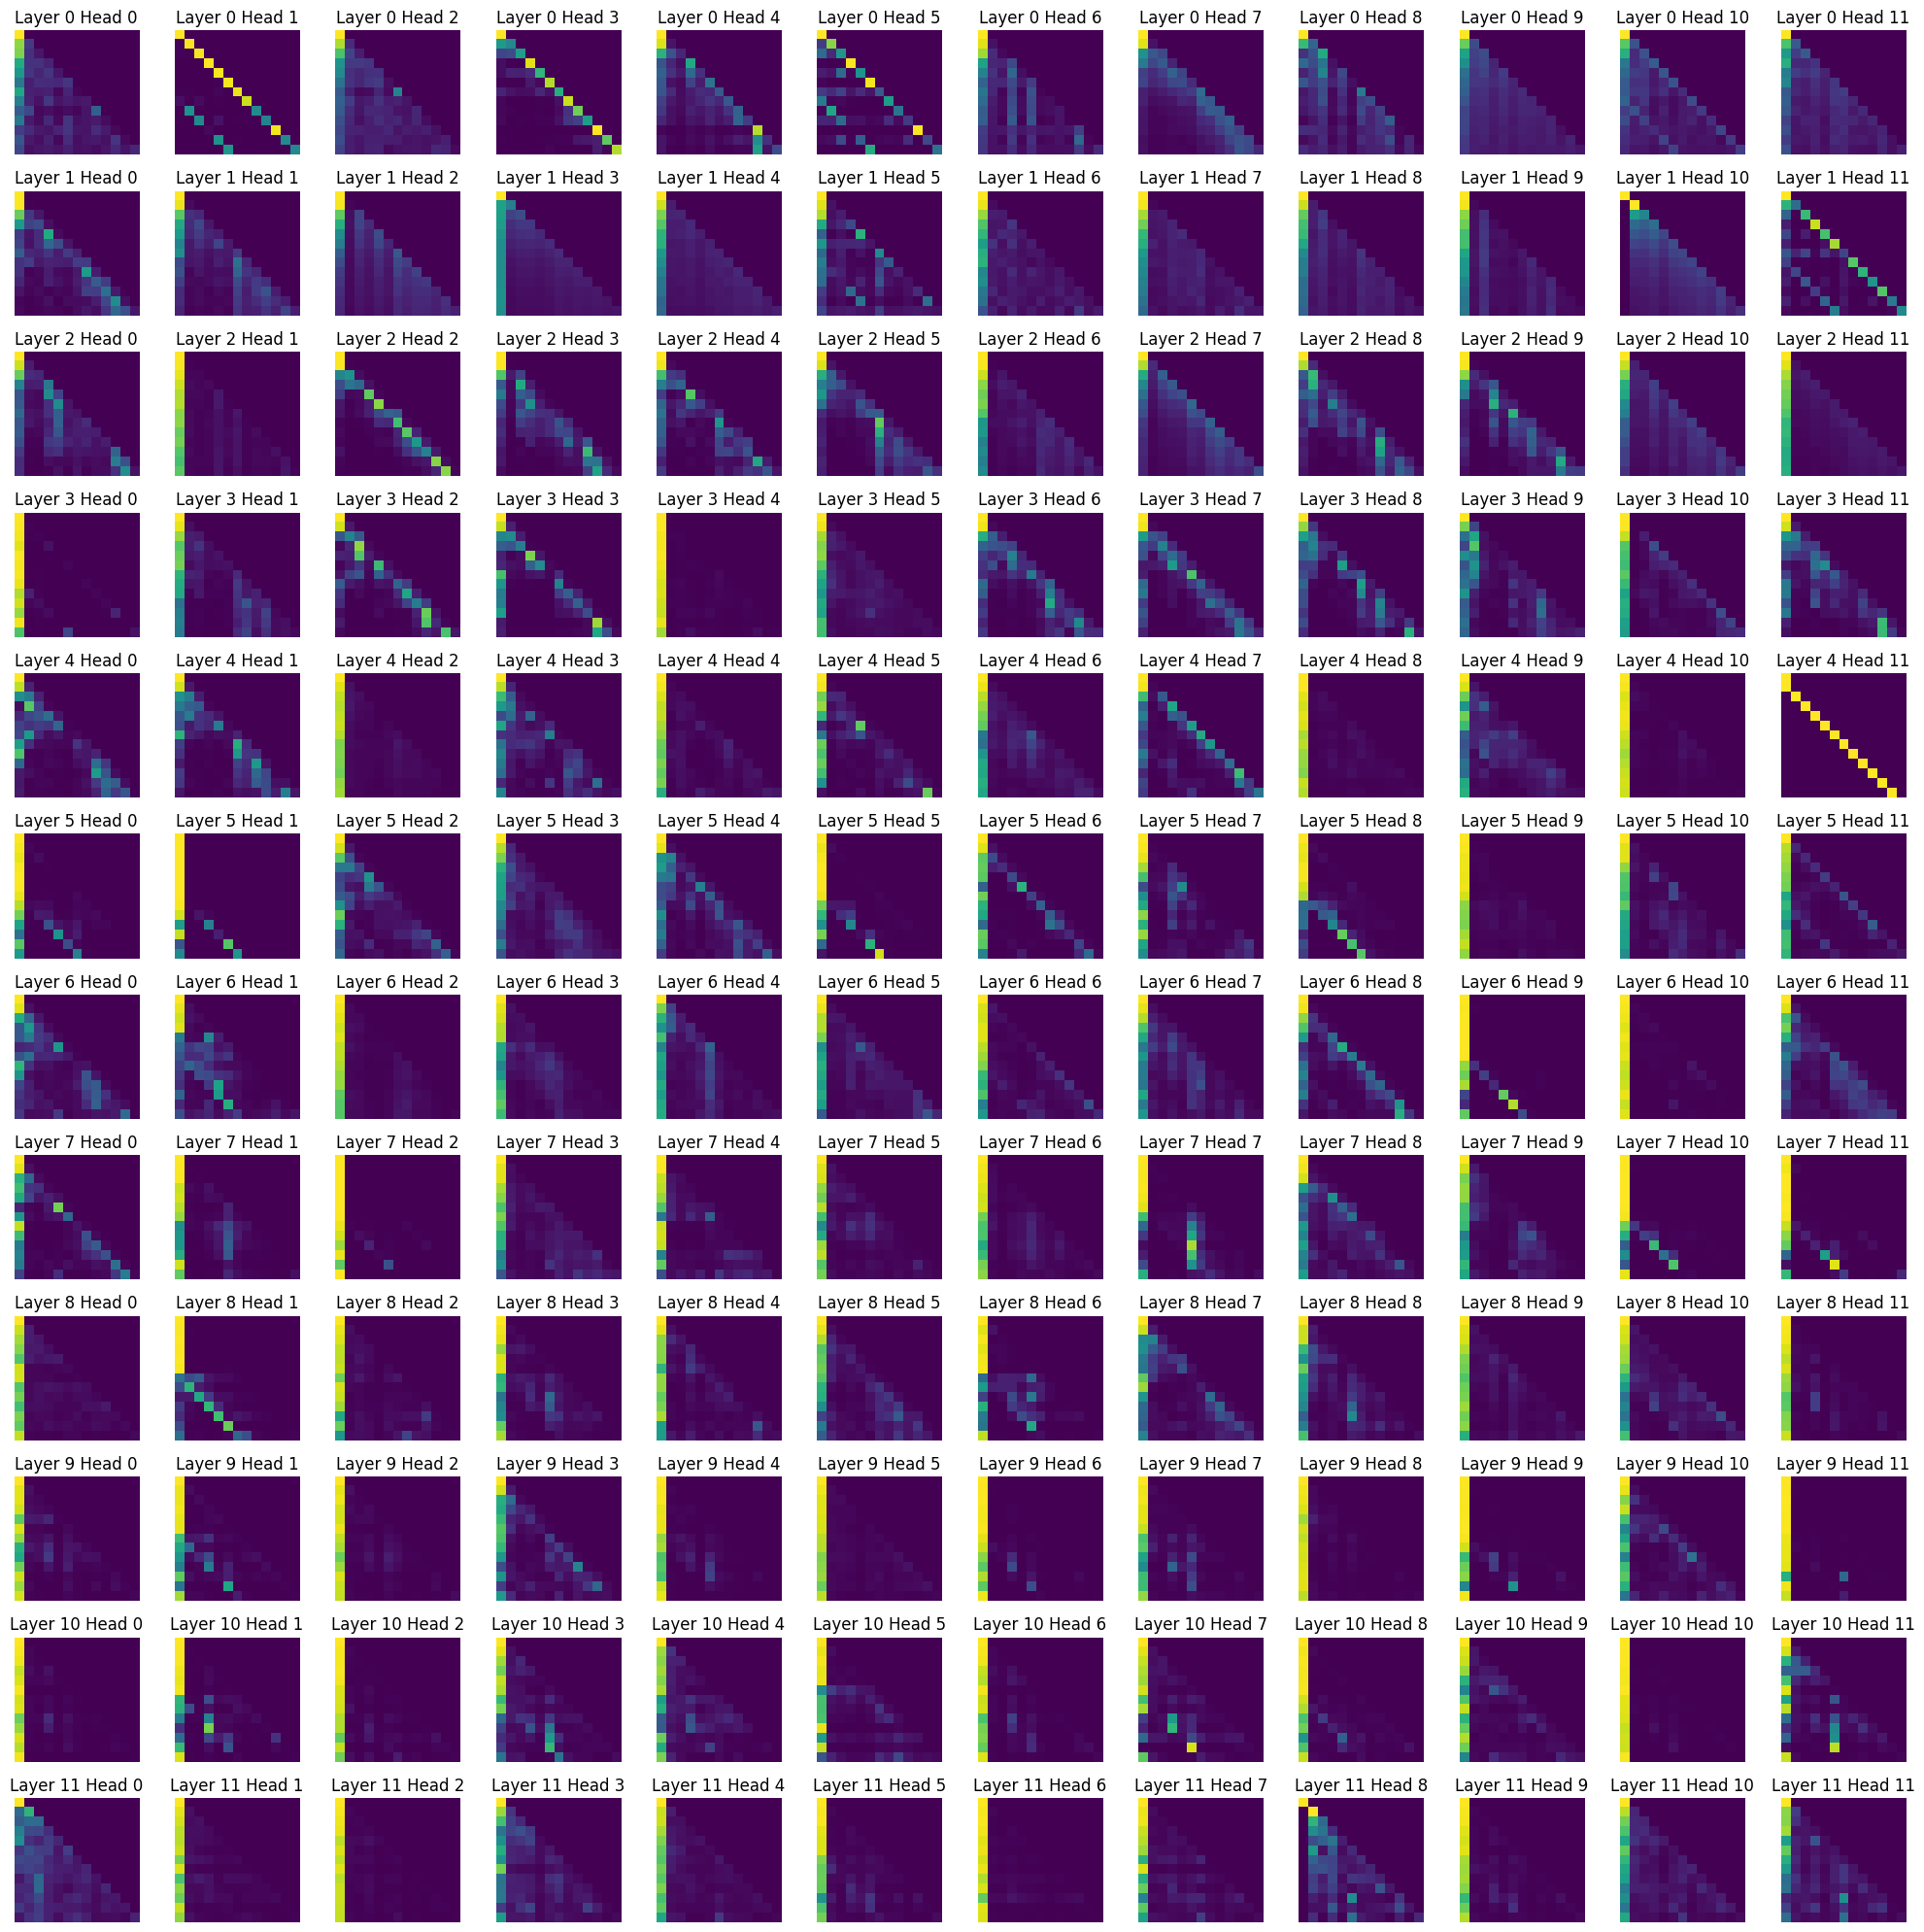

In [24]:
import matplotlib.pyplot as plt

n_layers = model.config.n_layer
n_heads = model.config.n_head

fig, axs = plt.subplots(n_layers, n_heads, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    for j, head in enumerate(layer[0]):
        axs[i, j].imshow(head.detach().numpy())
        axs[i, j].set_title(f'Layer {i} Head {j}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Perhaps it's easier to look into each average attention map

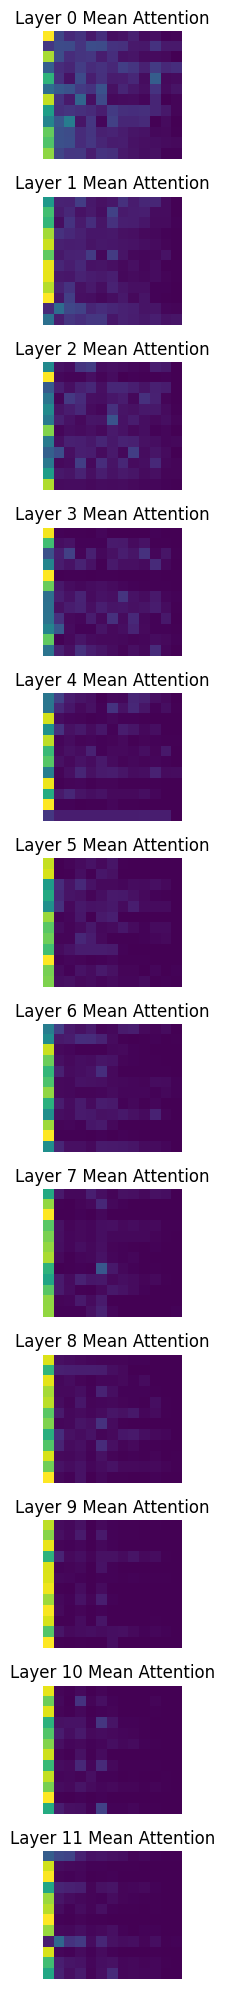

In [41]:
fig, axs = plt.subplots(n_layers, 1, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    axs[i].imshow(layer[0].mean(dim=1).detach().numpy())
    axs[i].set_title(f'Layer {i} Mean Attention')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

This is wrong: why are there values greater than zero above the diagonal?

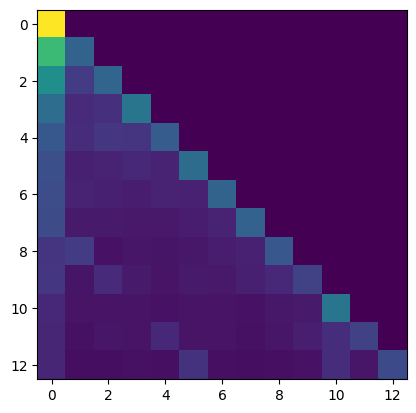

In [42]:
plt.imshow(output.attentions[0].mean(dim=1).detach().numpy()[0])

Ah, apprently I was doing the following: `b h n n -> b h n`, instead of `b h n n -> b n n`. We correct it thus:

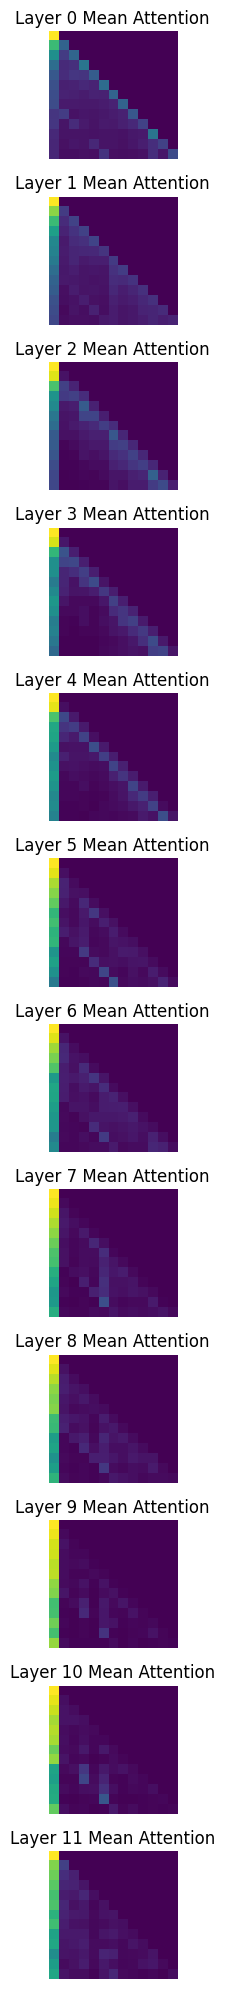

In [43]:
fig, axs = plt.subplots(n_layers, 1, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    axs[i].imshow(layer[0].mean(dim=0).detach().numpy())
    axs[i].set_title(f'Layer {i} Mean Attention')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Let's add the words to the left and to the bottom of each plot, to better understand what is happening in the cross-attention:

In [45]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_assisted_decoding',
 '_attn_implementation',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_dola_decoding',
 '_expan

In [51]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_added_tokens_decoder',
 '_added_tokens_encoder',
 '_additional_special_tokens',
 '_auto_class',
 '_batch_encode_plus',
 '_batch_prepare_for_model',
 '_bos_token',
 '_call_one',
 '_cls_token',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_create_repo',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_eventually_correct_t5_max_length',
 '_from_pretrained',
 '_get_files_timestamps',
 '_get_padding_truncation_strate

In [71]:
tokenizer.decode(encoded_input.input_ids[0])

'It was the best of times, it was the worst of times'

In [75]:
[tokenizer.decode(t).strip() for t in encoded_input.input_ids[0]]

['It',
 'was',
 'the',
 'best',
 'of',
 'times',
 ',',
 'it',
 'was',
 'the',
 'worst',
 'of',
 'times']

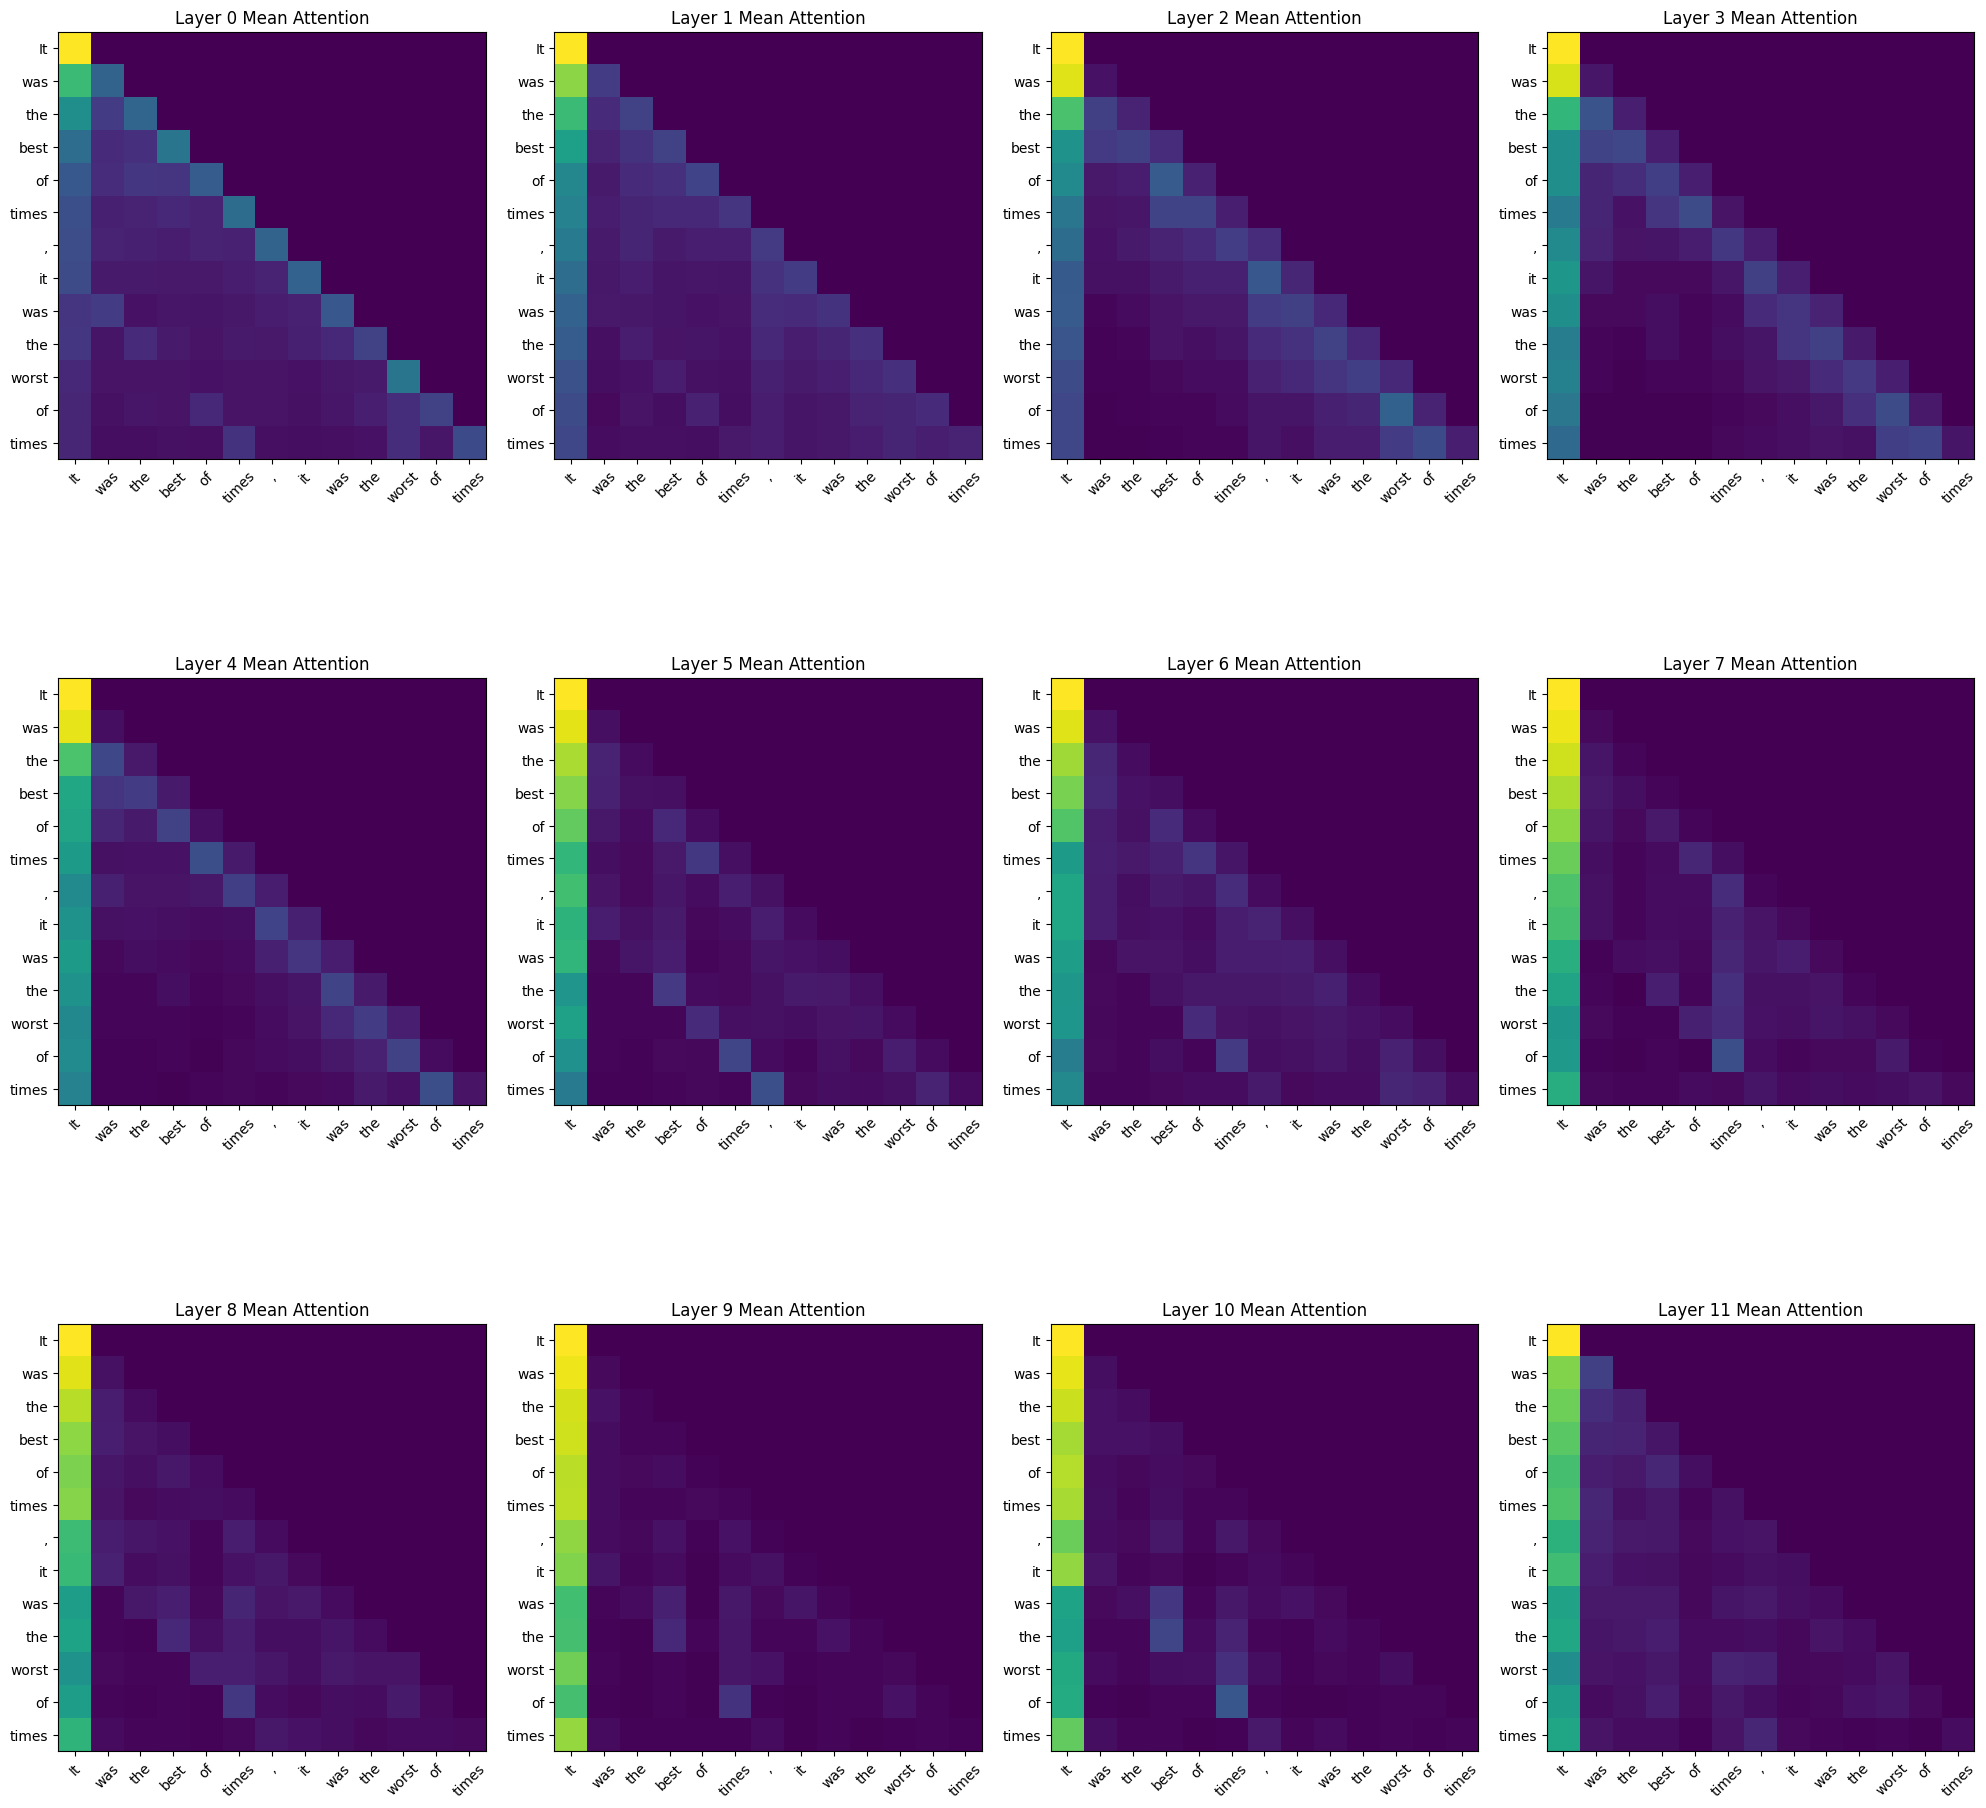

In [77]:
import numpy as np

grid_width = max(int(np.ceil(np.sqrt(n_layers))), 1)
grid_height = max((n_layers - 1) // grid_width + 1, 1)

fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))

for i, layer in enumerate(output.attentions):
    axs[i // grid_width, i % grid_width].imshow(layer[0].mean(dim=0).detach().numpy())
    axs[i // grid_width, i % grid_width].set_title(f'Layer {i} Mean Attention')
    
    # Add the text for each tick in the x and y axis
    ticks = [tokenizer.decode(t).strip() for t in encoded_input.input_ids[0]]
    axs[i // grid_width, i % grid_width].set_xticks(range(len(ticks)))
    axs[i // grid_width, i % grid_width].set_xticklabels(ticks, rotation=45)
    axs[i // grid_width, i % grid_width].set_yticks(range(len(ticks)))
    axs[i // grid_width, i % grid_width].set_yticklabels(ticks)

plt.tight_layout()
plt.show()

## Parameters
Let's count the total number of parameters with and without freezing the specified layers in the paper:

In [85]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

124,439,808 total parameters.


Now, as the paper "says", we need to freeze all layers except for the `LayerNorm`:

![image](https://github.com/user-attachments/assets/06ae7bb0-39be-40f5-9549-25da7ccc6293)

Let's see how many parameters are left that are trainable then:

In [87]:
for name, param in model.named_parameters():
    if 'ln' in name or 'wpe' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

total_params_frozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params_frozen:,} total parameters after freezing all but layer norm and position embeddings.')
print(f'As a percentage, this is {total_params_frozen / total_params * 100:.2f}% of the total parameters.')

824,832 total parameters after freezing all but layer norm and position embeddings.
As a percentage, this is 0.66% of the total parameters.


This is extremely similar to a LoRA in the end, which I find interesting.